In [84]:
import pandas as pd
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [85]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [86]:
def load_data(annotation_file, image_dir, target_size=(224, 224)):
    annotations = pd.read_csv(annotation_file)

    images = []
    bboxes = []

    for _, row in annotations.iterrows():
        x_min = row['xmin']
        y_min = row['ymin']
        x_max = row['xmax']
        y_max = row['ymax']
        width = row['width']
        height = row['height']
        
        bbox = [x_min / width, y_min / height, x_max / width, y_max / height]
        
        img_path = os.path.join(image_dir, row['filename'])
        
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        img = cv2.resize(img, target_size)
        
        images.append(img)
        bboxes.append(bbox)

    images = np.array(images) / 255.0
    bboxes = np.array(bboxes)
    
    return images, bboxes


In [87]:
annotation_file = r'D:\table_detection\nutrition table.v2i.tensorflow\train\_annotations.csv'
image_dir = r'D:\table_detection\nutrition table.v2i.tensorflow\train'

# Load data
images, bboxes = load_data(annotation_file, image_dir)

In [88]:
def normalize_bbox(bbox, image_width, image_height):
    return [bbox[0] / image_width, bbox[1] / image_height, bbox[2] / image_width, bbox[3] / image_height]

def denormalize_bbox(bbox, image_width, image_height):
    return [int(bbox[0] * image_width), int(bbox[1] * image_height), int(bbox[2] * image_width), int(bbox[3] * image_height)]

def augment_data(image, bboxes, class_labels):
    image_height, image_width = image.shape[:2]

    normalized_bboxes = [normalize_bbox(bbox, image_width, image_height) for bbox in bboxes]

    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(limit=15, p=0.3),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.4),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    augmented = transform(image=image, bboxes=normalized_bboxes, class_labels=class_labels)

    augmented_bboxes = [denormalize_bbox(bbox, image_width, image_height) for bbox in augmented['bboxes']]
    return augmented['image'], augmented_bboxes


In [89]:
def create_table_detection_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        (Dropout(0.3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        (Dropout(0.3)),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(4, activation='sigmoid')  # Output bounding box coordinates (normalized)
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    # model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

In [90]:
X_train, X_test, y_train, y_test = train_test_split(images, bboxes, test_size=0.2, random_state=42)

In [91]:
optimizer = Adam(learning_rate=0.00001)

In [ ]:
model = create_table_detection_model(input_shape=(224, 224, 3))
checkpoint = ModelCheckpoint('table_detection.h5', monitor='val_loss', save_best_only=True)

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 conv2d_22 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 54, 54, 64)       

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Melatih model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=50, batch_size=8, callbacks=[early_stopping, checkpoint])

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [50]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [51]:
print("Model's Input Layer:", model.layers[0].input_shape)

Model's Input Layer: (None, 224, 224, 3)


In [52]:
print("Model's ouput Layer:", model.output_shape)

Model's ouput Layer: (None, 4)


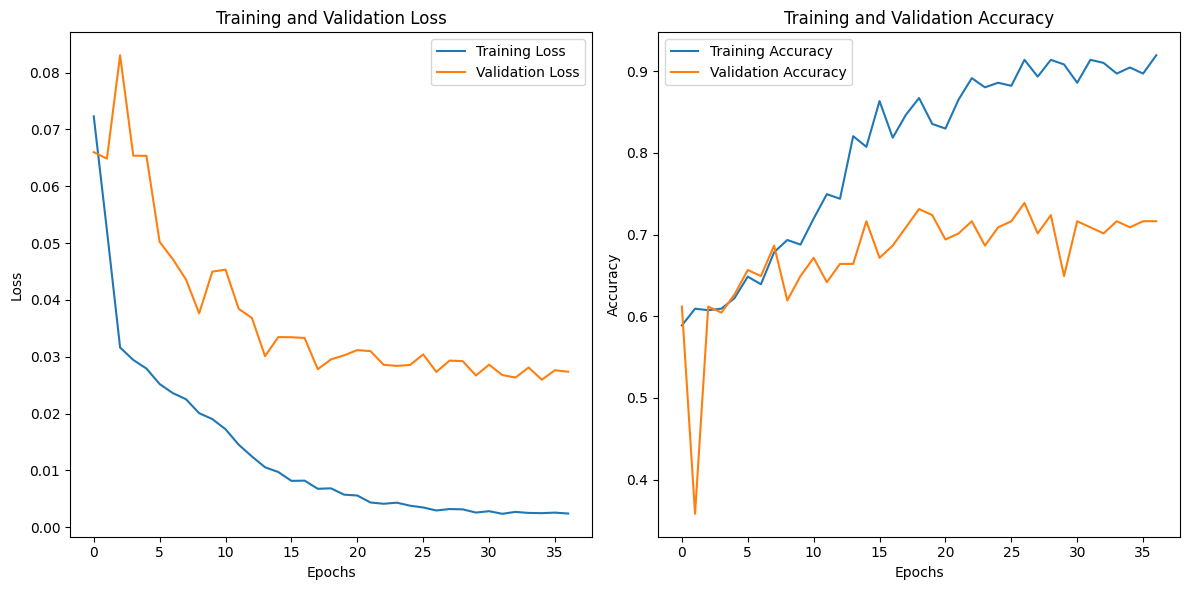

In [53]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


1/1 [==============================] - 0s 59ms/step


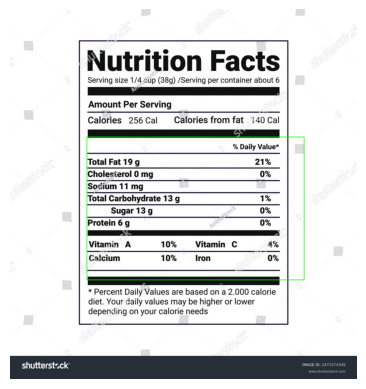

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_prediction(model, img_path, target_size=(224, 224)):
    # Load the input image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return

    # Resize the image to the input size of the model
    img_resized = cv2.resize(img, target_size)
    
    # Normalize the image (same preprocessing as during training)
    img_normalized = img_resized / 255.0
    img_normalized = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

    # Make the prediction
    bbox_pred = model.predict(img_normalized)[0]  # Get the predicted bounding box

    # Denormalize the bounding box (if the bounding box was normalized during training)
    h, w = img.shape[:2]
    bbox = denormalize_bbox(bbox_pred, w, h)

    # Draw the bounding box on the image
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

    # Display the image with the bounding box
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for plotting
    plt.axis('off')
    plt.show()

# Example usage
img_path = r'C:\Users\theod\Downloads\uwa.jpg' # Path to your image
visualize_prediction(model, img_path)


1/1 [==============================] - 0s 15ms/step


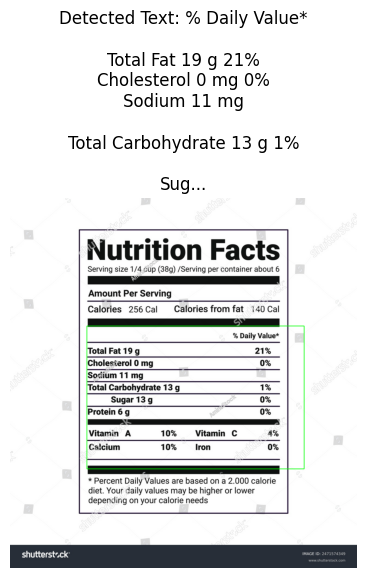

Detected Text:
% Daily Value*

Total Fat 19 g 21%
Cholesterol 0 mg 0%
Sodium 11 mg

Total Carbohydrate 13 g 1%

Sugar 13 g 0%
Protein 6 g 0%
SS
Vitamin A 10% Vitamin C 4%

Calcium 10% Iron 0%



In [55]:
import pytesseract
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to perform OCR on the predicted bounding box
def detect_text_in_bounding_box(model, img_path, target_size=(224, 224)):
    # Load the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return
    
    # Resize the image to the input size of the model
    img_resized = cv2.resize(img, target_size)
    
    # Normalize the image (same preprocessing as during training)
    img_normalized = img_resized / 255.0
    img_normalized = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

    # Make prediction with the model (Get the predicted bounding box)
    bbox_pred = model.predict(img_normalized)[0]  # Get the predicted bounding box

    # Denormalize the bounding box (from [0, 1] to pixel values)
    h, w = img.shape[:2]
    bbox = denormalize_bbox(bbox_pred, w, h)

    # Extract the region of interest (ROI) from the image
    x_min, y_min, x_max, y_max = bbox
    roi = img[y_min:y_max, x_min:x_max]

    # Apply OCR to the ROI (Region of Interest)
    ocr_text = pytesseract.image_to_string(roi)

    # Display the image with the bounding box and OCR text
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)  # Draw the bounding box

    # Display the image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(f"Detected Text: {ocr_text[:100]}...")  # Show the first 100 chars of detected text
    plt.axis('off')
    plt.show()

    # Print the detected text
    print("Detected Text:")
    print(ocr_text)

# Example usage
img_path = r'C:\Users\theod\Downloads\uwa.jpg'  # Path to your image
detect_text_in_bounding_box(model, img_path)


1/1 [==============================] - 0s 20ms/step


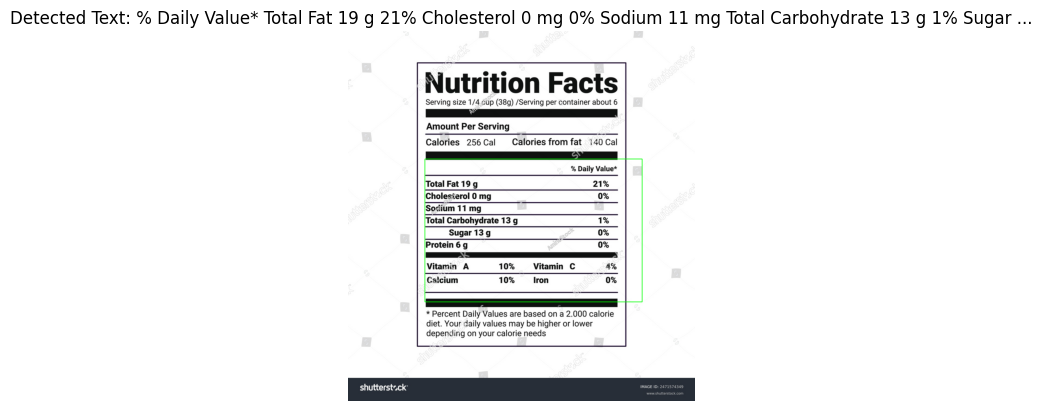

Extracted Nutrients:
protein: 6
fat: 19
sugar: 13


In [56]:
import pytesseract
import cv2
import numpy as np
import re
import matplotlib.pyplot as plt

# Function to detect text from bounding box and extract nutrient values
def detect_and_extract_nutrients(model, img_path, target_size=(224, 224)):
    # Load the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return
    
    # Resize the image to the input size of the model
    img_resized = cv2.resize(img, target_size)
    
    # Normalize the image (same preprocessing as during training)
    img_normalized = img_resized / 255.0
    img_normalized = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

    # Make prediction with the model (Get the predicted bounding box)
    bbox_pred = model.predict(img_normalized)[0]  # Get the predicted bounding box

    # Denormalize the bounding box (from [0, 1] to pixel values)
    h, w = img.shape[:2]
    bbox = denormalize_bbox(bbox_pred, w, h)

    # Extract the region of interest (ROI) from the image
    x_min, y_min, x_max, y_max = bbox
    roi = img[y_min:y_max, x_min:x_max]

    # Apply OCR to the ROI (Region of Interest)
    ocr_text = pytesseract.image_to_string(roi)

    # Clean up the extracted text (remove extra spaces, newlines, etc.)
    ocr_text = ' '.join(ocr_text.split())

    # Extract the nutrients from the OCR result using regular expressions
    nutrients = extract_nutrients_from_text(ocr_text)

    # Draw the bounding box on the image for visualization
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)  # Draw the bounding box

    # Display the image with the bounding box and OCR text
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(f"Detected Text: {ocr_text[:100]}...")  # Show the first 100 chars of detected text
    plt.axis('off')
    plt.show()

    # Print the extracted nutrients
    print("Extracted Nutrients:")
    for nutrient, value in nutrients.items():
        print(f"{nutrient}: {value}")

# Regular expression pattern to extract nutrients
def extract_nutrients_from_text(ocr_text):
    # Nutrients regex patterns for calories, protein, fat, and sugar
    patterns = {
        "calories": r"(calories?|energy)\s*[:\-]?\s*(\d+)",
        "protein": r"(protein)\s*[:\-]?\s*(\d+)",
        "fat": r"(fat)\s*[:\-]?\s*(\d+)",
        "sugar": r"(sugar)\s*[:\-]?\s*(\d+)"
    }
    
    nutrients = {}
    
    for nutrient, pattern in patterns.items():
        match = re.search(pattern, ocr_text, re.IGNORECASE)
        if match:
            nutrients[nutrient] = match.group(2)  # The number part of the match
    
    return nutrients

# Example usage
img_path = r'C:\Users\theod\Downloads\uwa.jpg'  # Path to your image
detect_and_extract_nutrients(model, img_path)


1/1 [==============================] - 0s 17ms/step


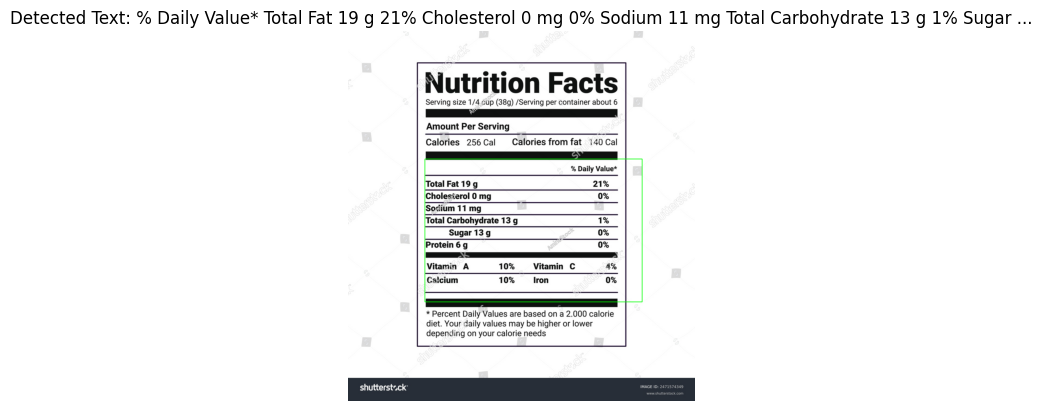

Extracted Nutrients:
protein: 6
fat: 19
sugar: 13


In [57]:
import pytesseract
import cv2
import numpy as np
import re
import matplotlib.pyplot as plt

# Function to denormalize bounding box coordinates (from [0, 1] to pixel values)
def denormalize_bbox(bbox, img_width, img_height):
    x_min = int(bbox[0] * img_width)
    y_min = int(bbox[1] * img_height)
    x_max = int(bbox[2] * img_width)
    y_max = int(bbox[3] * img_height)
    return [x_min, y_min, x_max, y_max]

# Function to detect text from bounding box and extract nutrient values
def detect_and_extract_nutrients(model, img_path, target_size=(224, 224)):
    # Load the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return
    
    # Resize the image to the input size of the model
    img_resized = cv2.resize(img, target_size)
    
    # Normalize the image (same preprocessing as during training)
    img_normalized = img_resized / 255.0
    img_normalized = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

    # Make prediction with the model (Get the predicted bounding box)
    bbox_pred = model.predict(img_normalized)[0]  # Get the predicted bounding box

    # Denormalize the bounding box (from [0, 1] to pixel values)
    h, w = img.shape[:2]
    bbox = denormalize_bbox(bbox_pred, w, h)

    # Extract the region of interest (ROI) from the image
    x_min, y_min, x_max, y_max = bbox
    roi = img[y_min:y_max, x_min:x_max]

    # Apply OCR to the ROI (Region of Interest)
    ocr_text = pytesseract.image_to_string(roi)

    # Clean up the extracted text (remove extra spaces, newlines, etc.)
    ocr_text = ' '.join(ocr_text.split())

    # Extract the nutrients from the OCR result using regular expressions
    nutrients = extract_nutrients_from_text(ocr_text)

    # Draw the bounding box on the image for visualization
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)  # Draw the bounding box

    # Display the image with the bounding box and OCR text
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(f"Detected Text: {ocr_text[:100]}...")  # Show the first 100 chars of detected text
    plt.axis('off')
    plt.show()

    # Print the extracted nutrients
    print("Extracted Nutrients:")
    for nutrient, value in nutrients.items():
        print(f"{nutrient}: {value}")

# Regular expression pattern to extract nutrients
def extract_nutrients_from_text(ocr_text):
    # Nutrients regex patterns for calories, protein, fat, and sugar
    patterns = {
        "calories": r"(calories?|energy)\s*[:\-]?\s*(\d+)",
        "protein": r"(protein)\s*[:\-]?\s*(\d+)",
        "fat": r"(fat)\s*[:\-]?\s*(\d+)",
        "sugar": r"(sugar)\s*[:\-]?\s*(\d+)"
    }
    
    nutrients = {}
    
    for nutrient, pattern in patterns.items():
        match = re.search(pattern, ocr_text, re.IGNORECASE)
        if match:
            nutrients[nutrient] = match.group(2)  # The number part of the match
    
    return nutrients

# Example usage
img_path = r'C:\Users\theod\Downloads\uwa.jpg'  # Path to your image
detect_and_extract_nutrients(model, img_path)


In [21]:
# # Convert the model to TFLite format
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# # converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# tflite_model = converter.convert()

# # Save TFLite model
# tflite_model_path = "ocr_74.tflite"
# with open(tflite_model_path, 'wb') as f:
#     f.write(tflite_model)

# print(f"Model saved as TFLite: {tflite_model_path}")
